<a href="https://colab.research.google.com/github/ouldsidy/Projets/blob/main/ProjetDeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction :

Notre projet est un problème de classification d'images. je vais réaliser un classificateur d'image via tensorflow et keras.

On va commencer par entraîner simplement un petit ConvNet sur notre petit ensemble de jeu d'entrainement, puis nous évaluerons ses performances. 

Pour atténuer un possible sur-ajustement, on va utiliser la téchnique de l'augmentation de données.

A la fin, on va utiliser un modèle pré-entraîné : 
- l'extraction de caractéristiques avec un réseau pré-entraîné et 
- le réglage de précision d'un réseau pré-entrainé.



**Packages**

In [1]:
# data visualisation and manipulation
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf                
from tqdm import tqdm

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import InputLayer, Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomTranslation

In [15]:
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
class_names = ['nathalie', 'keira', 'others']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (180, 180)

**Téléchargement des données**

On va écrire une fonction load_data qui charge les images et les étiquettes du dossier.

In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    #datasets = [data_train, data_validation, data_test]
    datasets = ['../content/drive/MyDrive/AppliDeepL/train', '../content/drive/MyDrive/AppliDeepL/test','../content/drive/MyDrive/AppliDeepL/val']
    
    
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output
        
        

In [5]:
(train_images, train_labels), (test_images, test_labels), (val_images, val_labels) = load_data()

Loading ../content/drive/MyDrive/AppliDeepL/train


100%|██████████| 143/143 [00:04<00:00, 29.02it/s]


Loading ../content/drive/MyDrive/AppliDeepL/test


100%|██████████| 56/56 [01:06<00:00,  1.18s/it]


Loading ../content/drive/MyDrive/AppliDeepL/val


100%|██████████| 56/56 [01:13<00:00,  1.32s/it]


**Exploration du jeu de données**

Nous pouvons nous demander :

Combien d'images nous avons dans nos ensembles d'entraînement, de validation et de test ?

Quelle est la taille des images ?

Quelle est la proportion de chaque catégorie observée ?

In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

In [ ]:
n_train = train_labels.shape[0]
n_val=val_labels.shape[0]
n_test = test_labels.shape[0]

print ("Nombre d'images dans l'ensemble d'entraînement: {}".format(n_train))
print ("Nombre d'images dans l'ensemble de validation : {}".format(n_val))
print ("Nombre d'images dans l'ensemble de test: {}".format(n_test))
print ("Dimension des images: {}".format(IMAGE_SIZE))

Nombre d'images dans l'ensemble d'entraînement: 429
Nombre d'images dans l'ensemble de validation : 168
Nombre d'images dans l'ensemble de test: 168
Dimension des images: (180, 180)


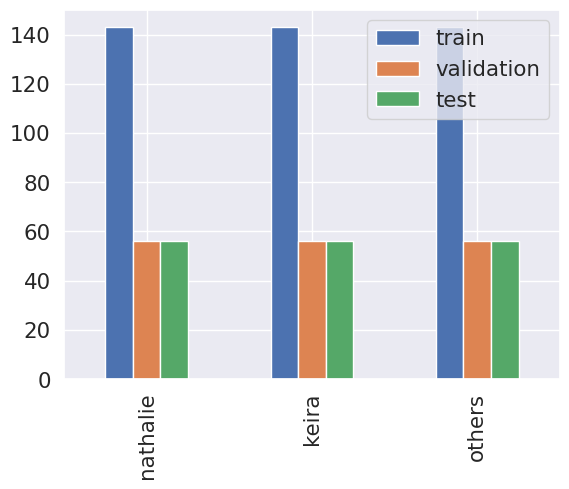

In [ ]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, validation_counts = np.unique(val_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts, 'validation':validation_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

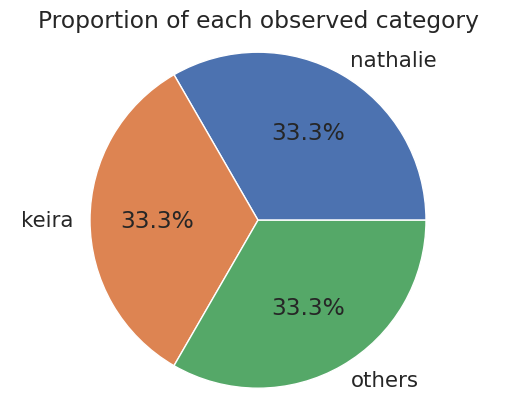

In [ ]:
plt.pie(train_counts,
        explode=(0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [6]:
# Modifie l'echelle des valeurs des images
train_images = train_images / 255.0 
val_images=val_images/ 255.0 
test_images = test_images / 255.0

**Visualisation de données**





Nous pouvons afficher les 25 premières images de l'ensemble d'entraînement directement avec une boucle pour obtenir une meilleure vue

In [ ]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Quelques exemples d'images du jeu de données", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

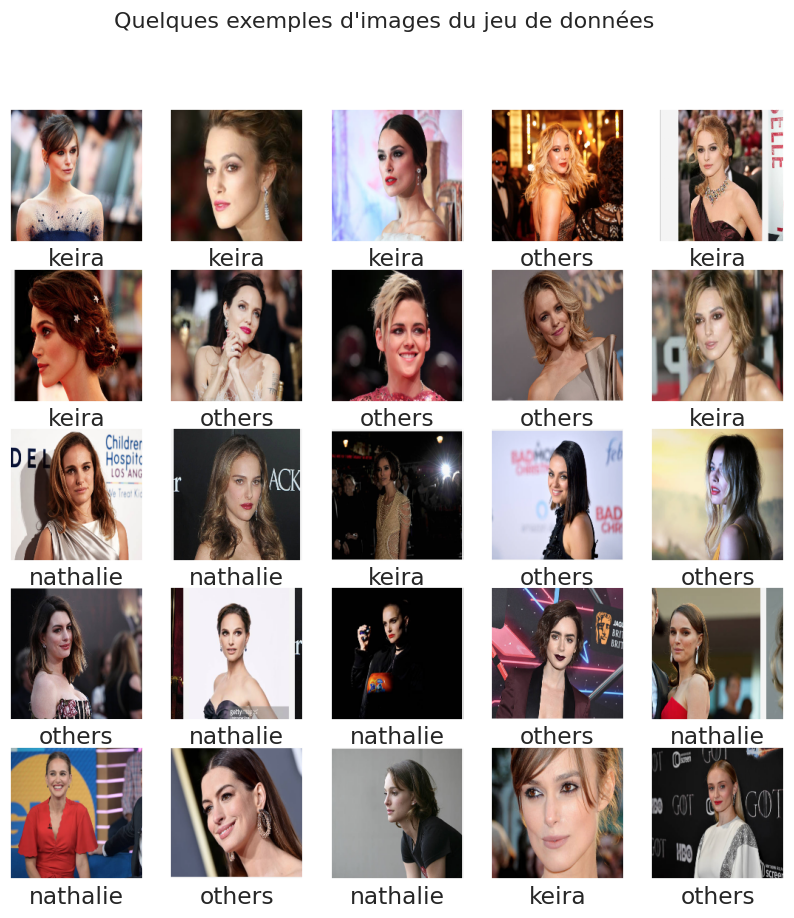

In [ ]:
display_examples(class_names, train_images, train_labels)

## Création de modèles simples

Les étapes sont les suivantes :

Construire le modèle,

Compiler le modèle,

Former / adapter les données au modèle,

Évaluer le modèle sur l'ensemble de validation ,

Effectuer une analyse d'erreur de notre modèle.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_1.fit( train_images, train_labels,
                      epochs  = 10,
      
                      validation_data = (val_images, val_labels)
                      )


Epoch 1/10
14/14 [==============================] - 14s 133ms/step - loss: 1.1210 - accuracy: 0.3333 - val_loss: 1.0975 - val_accuracy: 0.3988
Epoch 2/10
14/14 [==============================] - 1s 45ms/step - loss: 1.0966 - accuracy: 0.3590 - val_loss: 1.0928 - val_accuracy: 0.3452
Epoch 3/10
14/14 [==============================] - 1s 39ms/step - loss: 1.0829 - accuracy: 0.4056 - val_loss: 1.1230 - val_accuracy: 0.3750
Epoch 4/10
14/14 [==============================] - 1s 44ms/step - loss: 1.0712 - accuracy: 0.4056 - val_loss: 1.0526 - val_accuracy: 0.3929
Epoch 5/10
14/14 [==============================] - 1s 39ms/step - loss: 1.0247 - accuracy: 0.4709 - val_loss: 1.0400 - val_accuracy: 0.4881
Epoch 6/10
14/14 [==============================] - 1s 38ms/step - loss: 0.9844 - accuracy: 0.4965 - val_loss: 1.0458 - val_accuracy: 0.4643
Epoch 7/10
14/14 [==============================] - 1s 39ms/step - loss: 0.9147 - accuracy: 0.5548 - val_loss: 1.2011 - val_accuracy: 0.3631
Epoch 8/10


In [ ]:
# Créer un petit ConvNet
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=10, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Flatten()(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_1 = keras.Model(inputs=inputs, outputs=outputs)

model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_1.fit( train_images, train_labels,
                      epochs  = 20,
      
                      validation_data = (val_images, val_labels)
                      )

Epoch 1/20
14/14 [==============================] - 1s 39ms/step - loss: 14.3237 - accuracy: 0.3636 - val_loss: 10.8190 - val_accuracy: 0.3333
Epoch 2/20
14/14 [==============================] - 0s 21ms/step - loss: 3.8715 - accuracy: 0.4779 - val_loss: 3.4856 - val_accuracy: 0.4464
Epoch 3/20
14/14 [==============================] - 0s 21ms/step - loss: 1.7921 - accuracy: 0.5734 - val_loss: 1.7018 - val_accuracy: 0.4702
Epoch 4/20
14/14 [==============================] - 0s 20ms/step - loss: 0.5704 - accuracy: 0.7786 - val_loss: 1.4363 - val_accuracy: 0.4226
Epoch 5/20
14/14 [==============================] - 0s 19ms/step - loss: 0.3634 - accuracy: 0.8625 - val_loss: 1.3476 - val_accuracy: 0.4762
Epoch 6/20
14/14 [==============================] - 0s 20ms/step - loss: 0.2683 - accuracy: 0.9091 - val_loss: 1.3050 - val_accuracy: 0.4643
Epoch 7/20
14/14 [==============================] - 0s 18ms/step - loss: 0.1230 - accuracy: 0.9744 - val_loss: 1.3410 - val_accuracy: 0.4762
Epoch 8/20


**Tracé des courbes de perte et d'axactitude de prédiction pendant l'entraînement**

In [7]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(15,7))

    # Plot accuracy
    plt.subplot(221)
    plt.plot(history.history["accuracy"],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("Exactitude pendant l'entraînement et la validation")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
   # plt.title("train_loss vs val_loss")
    plt.title("Perte pendant l'entraînement et la validation")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

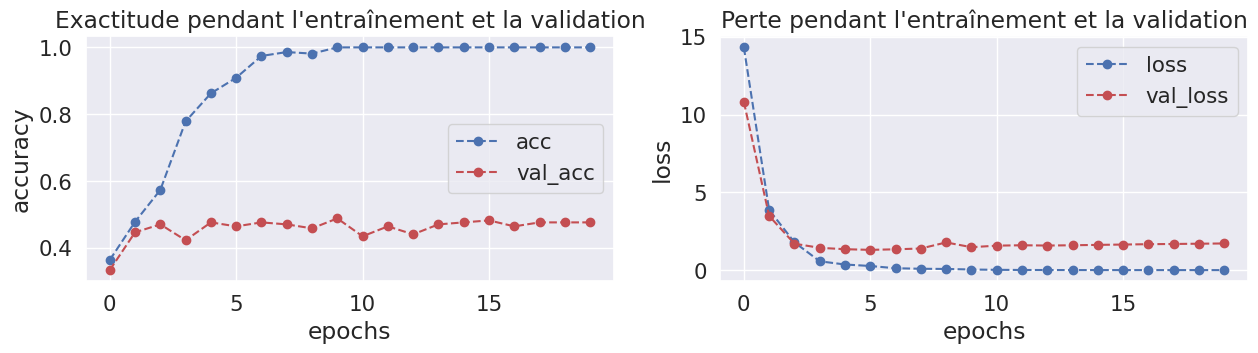

In [ ]:
plot_accuracy_loss(history)

Ces tracés sont caractéristique d'un sur-ajustement. L'exactitude de l'entrainement augmente linéairement dans le temps, jusqu'a atteindre près de 100%, alors que l'exactitude de la validation se stabilise à moins de 50%. La perte de validation atteint son minimum après seulement six époques, alors que la perte d'entrainement continue à diminuer à linéairement, jusqu'à ce qu'elle atteigne presque la valeur 0. 

Comme on a relativement peu d'exemple dans l'ensemble d'entrainement, le sur-ajustement sera notre principale préoccupation. On va maintenant utiliser la technique de l'augmentation de données.

## Utilisation de l'augmentation de données

**Définir une étape d'augmentation de données à ajouter à un modèle d'image**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Ici, on va définir un nouveau ConvNet qui inclut l'augmentation de données.

In [ ]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")]

history_2 = model.fit( train_images, train_labels,
                      epochs  = 100,
                      validation_data = (val_images, val_labels)
                      )

Epoch 1/100
14/14 [==============================] - 3s 70ms/step - loss: 1.1075 - accuracy: 0.3776 - val_loss: 1.0977 - val_accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - 1s 43ms/step - loss: 1.0978 - accuracy: 0.3939 - val_loss: 1.0943 - val_accuracy: 0.3929
Epoch 3/100
14/14 [==============================] - 1s 48ms/step - loss: 1.0914 - accuracy: 0.4103 - val_loss: 1.0704 - val_accuracy: 0.3869
Epoch 4/100
14/14 [==============================] - 1s 44ms/step - loss: 1.0888 - accuracy: 0.3613 - val_loss: 1.0563 - val_accuracy: 0.4643
Epoch 5/100
14/14 [==============================] - 1s 44ms/step - loss: 1.0562 - accuracy: 0.4476 - val_loss: 1.0446 - val_accuracy: 0.4464
Epoch 6/100
14/14 [==============================] - 1s 44ms/step - loss: 1.0419 - accuracy: 0.4615 - val_loss: 1.0527 - val_accuracy: 0.4643
Epoch 7/100
14/14 [==============================] - 1s 50ms/step - loss: 1.0476 - accuracy: 0.4662 - val_loss: 1.0392 - val_accuracy: 0.5060
Epoch 

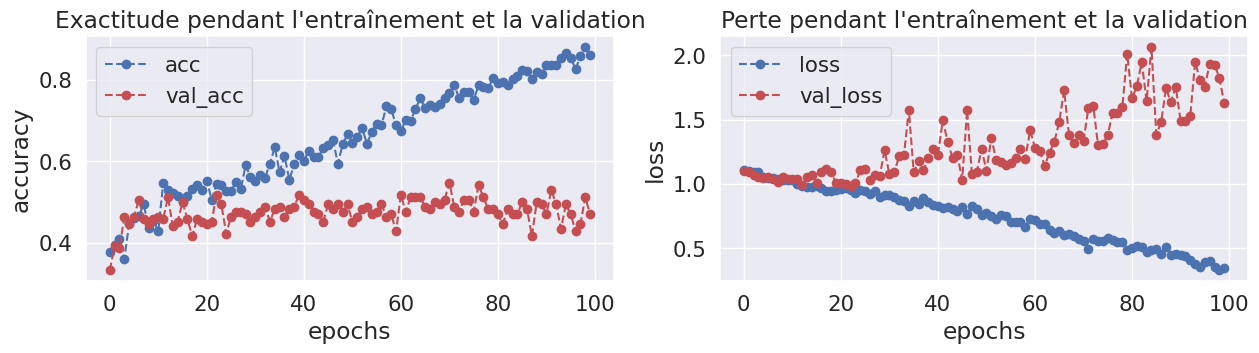

In [ ]:
plot_accuracy_loss(history_2)

En utilisant cette configuration d'augmentation de données et un dropout, on reduit un peu le sur-ajustement du modèle. On atteint une exactitude de  prédiction de $52.9  $%$ $. Soit une amélioration relative de $ 6 $%$ $ par rapport au mdèle non régularisé. 

L'étape suivante sera d'utilser un modèle pré-entraîné.

## Utilisantion d'un ConvNet pré-entraîné

Dans cette section, on va considerer un modèle de classification d'image  pré-entraîné.





**Instanciation de la base de convolution d'un modèle VGG16**



In [9]:
from keras.applications.vgg16 import VGG16

In [ ]:
conv_base= VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

La carte finale de carecteristiques est de la forme (5, 5, 512). C'est la carte sur la quelle on ajoutera un classifieur entièrement connecté.

**Extraction de caractéristiques à l'aide de la base de convolution pré-entraînée**

Dans cette partie, on va extraire des carateristiques de nos images en applant la méthode predict du modèle conv_base.

In [ ]:
train_features = conv_base.predict(train_images)
val_features= conv_base.predict(val_images)
test_features = conv_base.predict(test_images)

6/6 [==============================] - 0s 77ms/step


### **Extraction rapide des caractéristiques sans augmentation des données**

In [ ]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_05 = keras.Model(inputs, outputs)

model_05.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history_05 = model_05.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/50
14/14 [==============================] - 2s 71ms/step - loss: 9.4582 - accuracy: 0.4009 - val_loss: 8.1572 - val_accuracy: 0.3393
Epoch 2/50
14/14 [==============================] - 1s 61ms/step - loss: 4.8784 - accuracy: 0.5641 - val_loss: 4.2663 - val_accuracy: 0.4524
Epoch 3/50
14/14 [==============================] - 1s 74ms/step - loss: 2.1935 - accuracy: 0.7273 - val_loss: 4.1598 - val_accuracy: 0.5298
Epoch 4/50
14/14 [==============================] - 1s 88ms/step - loss: 1.1009 - accuracy: 0.8159 - val_loss: 3.1386 - val_accuracy: 0.5417
Epoch 5/50
14/14 [==============================] - 1s 90ms/step - loss: 0.7578 - accuracy: 0.8695 - val_loss: 3.0053 - val_accuracy: 0.5714
Epoch 6/50
14/14 [==============================] - 1s 52ms/step - loss: 0.4759 - accuracy: 0.8951 - val_loss: 3.0252 - val_accuracy: 0.6071
Epoch 7/50
14/14 [==============================] - 1s 85ms/step - loss: 0.1788 - accuracy: 0.9464 - val_loss: 2.9287 - val_accuracy: 0.6310
Epoch 8/50
14

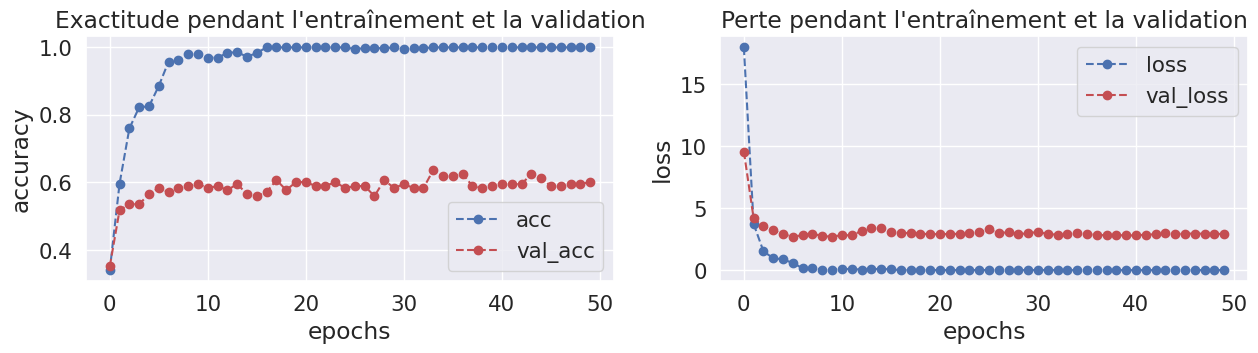

In [ ]:
plot_accuracy_loss(history)

On atteint une exactitude de prédiction de  63 %  . Ce qui est bien mieux que ce qu'on a obtenu avec un ConvNet simple. Mais les tracés indiquent aussi que notre modèle est un sur-ajustement, malgré l'utilisation du dropout avec un taux assez élevé. C'est parce que cette technique n'utilse pas l'augmentation de données, qui est essentielle pour éviter le sur-ajustement avec de petit ensemble de données d'images comme le notre.

In [ ]:
predictions = model_05(test_features)

In [ ]:
test_loss, test_accuracy = model_05.evaluate(test_features, test_labels, batch_size=64)

3/3 [==============================] - 0s 18ms/step - loss: 4.6143 - accuracy: 0.5060


In [ ]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     4.614346027374268
Test Accuracy: 0.5059523582458496


In [ ]:
inputs = keras.Input(shape=(x, y, z))
x = layers.Flatten()(inputs)
x = layers.Dense(512)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model_03 = keras.Model(inputs, outputs)

model_03.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model_03.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/50
14/14 [==============================] - 2s 46ms/step - loss: 17.9699 - accuracy: 0.3403 - val_loss: 9.5692 - val_accuracy: 0.3512
Epoch 2/50
14/14 [==============================] - 0s 33ms/step - loss: 3.7160 - accuracy: 0.5967 - val_loss: 4.1656 - val_accuracy: 0.5179
Epoch 3/50
14/14 [==============================] - 0s 33ms/step - loss: 1.5138 - accuracy: 0.7599 - val_loss: 3.5318 - val_accuracy: 0.5357
Epoch 4/50
14/14 [==============================] - 0s 31ms/step - loss: 0.9580 - accuracy: 0.8228 - val_loss: 3.2058 - val_accuracy: 0.5357
Epoch 5/50
14/14 [==============================] - 0s 27ms/step - loss: 0.8719 - accuracy: 0.8252 - val_loss: 2.9115 - val_accuracy: 0.5655
Epoch 6/50
14/14 [==============================] - 0s 20ms/step - loss: 0.5673 - accuracy: 0.8858 - val_loss: 2.6797 - val_accuracy: 0.5833
Epoch 7/50
14/14 [==============================] - 0s 8ms/step - loss: 0.1507 - accuracy: 0.9580 - val_loss: 2.8332 - val_accuracy: 0.5714
Epoch 8/50
14

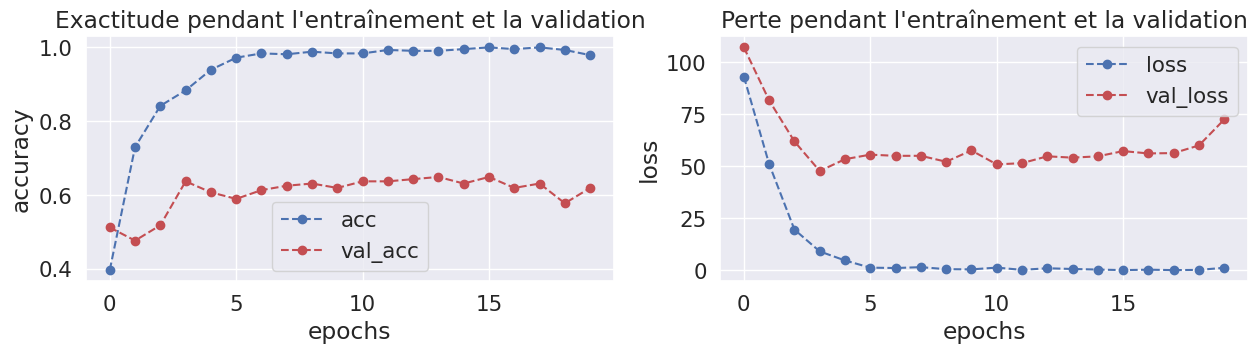

In [ ]:
plot_accuracy_loss(history)

On atteint une exactitude de prédiction de  64.88 %  . Ce qui est bien mieux que ce qu'on a obtenu avec un ConvNet simple. Mais les tracés indiquent aussi que notre modèle est un sur-ajustement presque dès le début, malgré l'utilisation du dropout avec un taux assez élevé. C'est parce que cette technique n'utilse pas l'augmentation de données, qui est essentielle pour éviter le sur-ajustement avec de petit ensemble de données d'images comme le notre.

### Extraction de caractéristique avec augmentation de données

Dans cette partie, on va utiliser une technique qui permet d'utilser l'augmentation de données pendant l'entraînement : prologeons le medèle con_base, et executons-le bout en bout sur les entrées.

**Instantiating and freezing the VGG16 convolutional base**

In [ ]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

**Ajout d'un classifieur entièrement connecté au-dessus de la base de convolution**

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model= keras.Model(inputs, outputs)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_images, train_labels,
    epochs=100,
    validation_data=(val_images,val_labels),
    callbacks=callbacks)

Epoch 1/100
14/14 [==============================] - 5s 187ms/step - loss: 6.4666 - accuracy: 0.3427 - val_loss: 4.9935 - val_accuracy: 0.3333
Epoch 2/100
14/14 [==============================] - 2s 167ms/step - loss: 3.7460 - accuracy: 0.3543 - val_loss: 2.7233 - val_accuracy: 0.3988
Epoch 3/100
14/14 [==============================] - 2s 165ms/step - loss: 2.2804 - accuracy: 0.3497 - val_loss: 1.3201 - val_accuracy: 0.3929
Epoch 4/100
14/14 [==============================] - 2s 152ms/step - loss: 1.9741 - accuracy: 0.3543 - val_loss: 2.0352 - val_accuracy: 0.3333
Epoch 5/100
14/14 [==============================] - 2s 153ms/step - loss: 1.5952 - accuracy: 0.3916 - val_loss: 1.3452 - val_accuracy: 0.3452
Epoch 6/100
14/14 [==============================] - 2s 180ms/step - loss: 1.4906 - accuracy: 0.3916 - val_loss: 1.0875 - val_accuracy: 0.3988
Epoch 7/100
14/14 [==============================] - 2s 153ms/step - loss: 1.7257 - accuracy: 0.3823 - val_loss: 1.3605 - val_accuracy: 0.3333

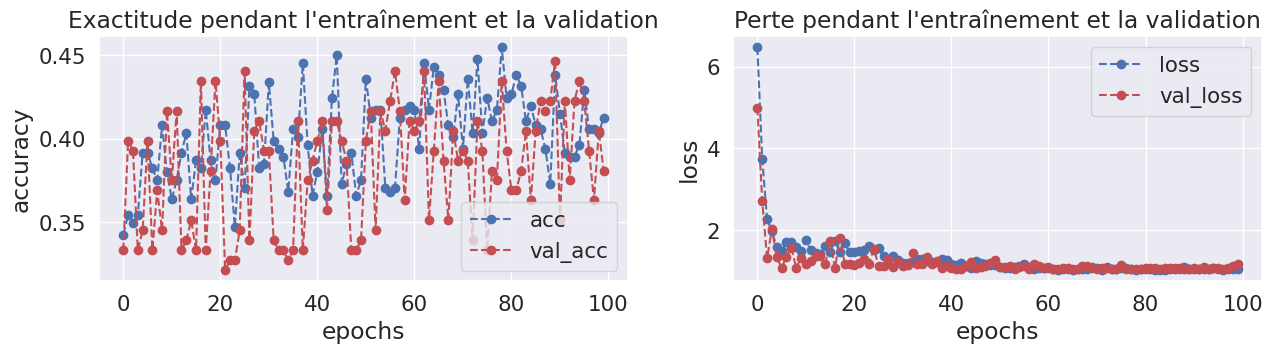

In [ ]:
plot_accuracy_loss(history)

###**Réglage de précision**

In [10]:
from keras.models import Model

model = VGG16(weights='imagenet', include_top=False)
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)

58889256/58889256 [==============================] - 3s 0us/step


In [11]:
features_train = model.predict(train_images)
features_validation=model.predict(val_images)
features_test = model.predict(test_images)

6/6 [==============================] - 0s 69ms/step


In [ ]:
from keras.layers import Input, Dense, Conv2D, Activation , MaxPooling2D, Flatten

model2 = VGG16(weights='imagenet', include_top=False)

input_shape = model2.layers[-4].get_input_shape_at(0) 
layer_input = Input(shape = (11, 11, 512)) 
x = layer_input
for layer in model2.layers[-4::1]:
    x = layer(x)
    
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(3,activation='softmax')(x)

# create the model
new_model = Model(layer_input, x)

new_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

history = new_model.fit(features_train, train_labels, batch_size=128, epochs=30, validation_data = (features_validation, val_labels))

Epoch 1/30
4/4 [==============================] - 9s 469ms/step - loss: 1.6943 - accuracy: 0.3427 - val_loss: 1.1135 - val_accuracy: 0.3333
Epoch 2/30
4/4 [==============================] - 0s 91ms/step - loss: 1.1347 - accuracy: 0.3380 - val_loss: 1.1076 - val_accuracy: 0.3631
Epoch 3/30
4/4 [==============================] - 0s 92ms/step - loss: 1.1084 - accuracy: 0.3590 - val_loss: 1.0930 - val_accuracy: 0.4167
Epoch 4/30
4/4 [==============================] - 0s 96ms/step - loss: 1.0974 - accuracy: 0.3520 - val_loss: 1.1020 - val_accuracy: 0.3393
Epoch 5/30
4/4 [==============================] - 0s 117ms/step - loss: 1.0964 - accuracy: 0.3660 - val_loss: 1.1073 - val_accuracy: 0.3333
Epoch 6/30
4/4 [==============================] - 0s 87ms/step - loss: 1.0734 - accuracy: 0.4196 - val_loss: 1.0940 - val_accuracy: 0.3571
Epoch 7/30
4/4 [==============================] - 0s 85ms/step - loss: 1.0520 - accuracy: 0.4732 - val_loss: 1.0893 - val_accuracy: 0.3929
Epoch 8/30
4/4 [=========

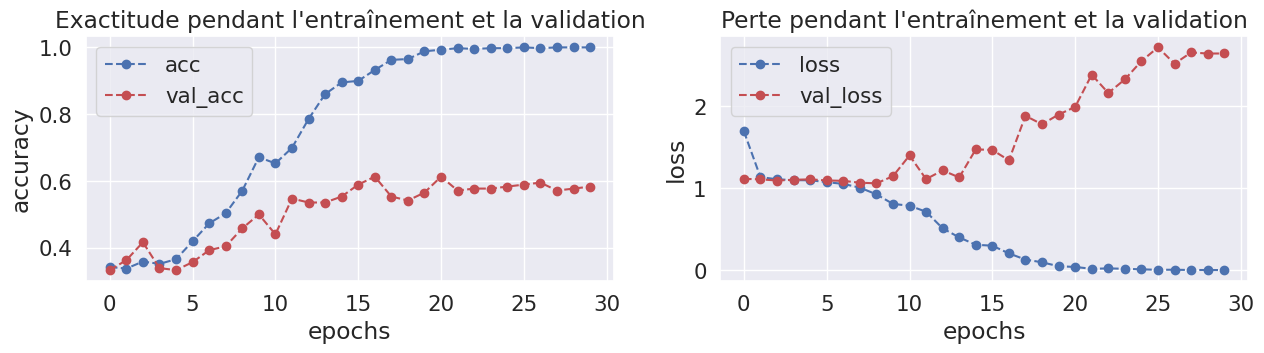

In [ ]:
plot_accuracy_loss(history)

**Évaluation du modèle sur le jeu de test**

In [ ]:
from sklearn.metrics import accuracy_score

predictions = new_model.predict(features_test)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

6/6 [==============================] - 1s 35ms/step
Accuracy : 0.5773809523809523
